# Frequency Task - PLSTM

This is the first task in the NIPS '16 paper "Phased LSTM: Accelerating Recurrent Network Training for Long or Event-based Sequences" by Daniel Neil, Michael Pfeiffer, and Shih-Chii Liu.  We begin with imports:

In [1]:
import glob
import sys
import numpy as np

from collections import defaultdict
from lasagne_utils import load_log
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


def get_min_mean_max(log_files, key='val_acc', clip_to_shortest=True, clip_length=None):
    logs = []
    for log_file in log_files:
        logs.append(load_log(log_file, append_dir=False))
    if clip_to_shortest:
        clip_length = np.min([len(log[key]) for log in logs])
    min_line = np.min([log[key][:clip_length] for log in logs], axis=0)
    mean_line = np.mean([log[key][:clip_length] for log in logs], axis=0)
    max_line = np.max([log[key][:clip_length] for log in logs], axis=0)
    return min_line, mean_line, max_line

def get_mean_std_at_pos(log_files, key, pos=-1):
    logs = []
    for log_file in log_files:
        logs.append(load_log(log_file, append_dir=False))
    scores = [log[key][pos] for log in logs]
    mean = np.mean(scores)
    std = np.std(scores)
    return mean, std

# Define some colors for plotting
PLSTM_COLOR='#33a02c'
BN_LSTM_COLOR='#6a3d9a'
LSTM_COLOR='#1f78b4'

In [2]:
# Find the results for this experiment and build a matrix with the averages
result_files = glob.glob('./models/freq_task*task1*final.log')
results = defaultdict(lambda:defaultdict(list) )

for result_file in result_files:
    result_attribs = result_file.split('_')
    net_type_key = '--'.join(result_attribs[3:6])
    run_type_key = '--'.join(result_attribs[6:12])
    results[run_type_key][net_type_key].append(result_file)

order_run_type = {'reg--samp--0--samp--res--0.0': 2,
                  'reg--samp--1--samp--res--0.1': 1,
                  'reg--samp--1--samp--res--1.0': 0}
order_net_type = {'plstm--bn--0':0, 'lstm--bn--1':1, 'lstm--bn--0':2}

means  = np.zeros( (3, len(results.values()[0])) )
stds   = np.zeros( (3, len(results.values()[0])) )
counts = np.zeros( (3, len(results.values()[0])) )
for run_key in results.keys():
    for net_key in results[run_key].keys():
        run_mean, run_std = get_mean_std_at_pos(results[run_key][net_key], 'val_acc', 69)
        run_idx, net_idx = order_run_type[run_key], order_net_type[net_key]
        means[run_idx][net_idx] = run_mean
        stds[run_idx][net_idx] = run_std
        counts[run_idx][net_idx] += len(results[run_key][net_key])
        
print('Means: {}'.format(means))
print('Stds: {}'.format(stds))
print('Counts: {}'.format(counts))
print('Done.')

Means: [[ 99.2578125  98.9453125  89.3359375]
 [ 99.609375   62.3828125  51.71875  ]
 [ 97.890625   74.296875   69.0234375]]
Stds: [[  0.22777156   0.38273277  18.89010157]
 [  0.27621359  18.63350857   0.71389324]
 [  0.57143511  17.72835112  13.33319346]]
Counts: [[ 5.  5.  5.]
 [ 5.  5.  5.]
 [ 5.  5.  5.]]
Done.


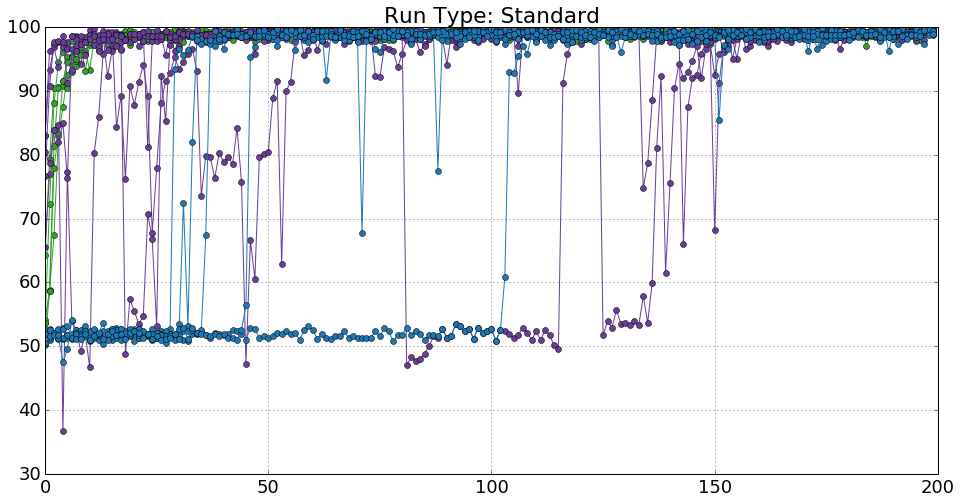

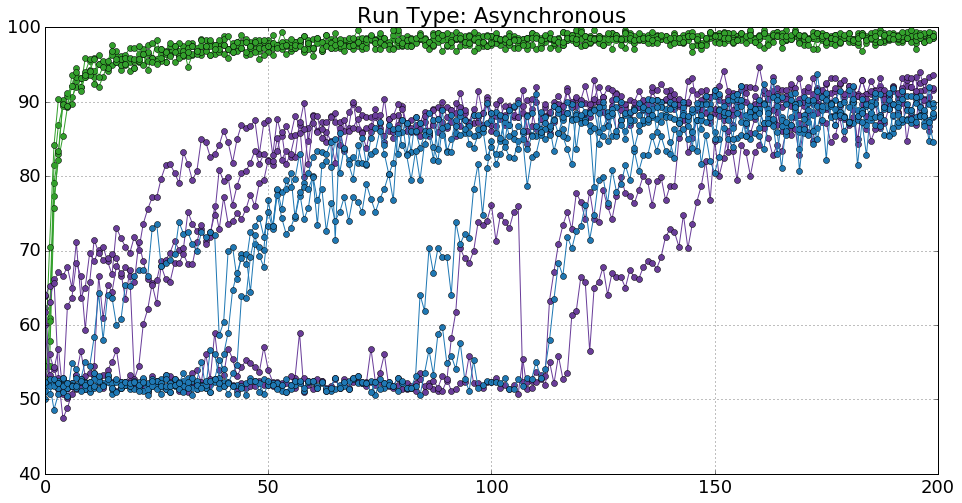

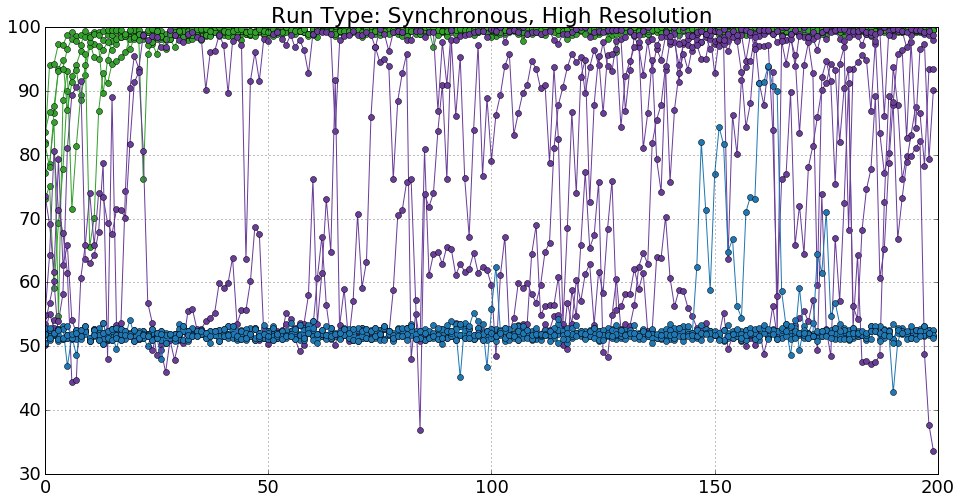

In [3]:
# Plot the results and the condition types
color_translation = {'plstm--bn--0': PLSTM_COLOR, 'lstm--bn--1': BN_LSTM_COLOR, 'lstm--bn--0': LSTM_COLOR}
run_translation = {'reg--samp--0--samp--res--0.0': 'Asynchronous',
                   'reg--samp--1--samp--res--0.1': 'Synchronous, High Resolution',
                   'reg--samp--1--samp--res--1.0': 'Standard'}

for run_key in results.keys()[::-1]:
    plt.figure(figsize=(16,8))
    plt.title('Run Type: {}'.format(run_translation[run_key]))
    for net_key in results[run_key].keys():
        for specific_run in results[run_key][net_key]:
            plt.plot(load_log(specific_run, append_dir=False)['val_acc'], 'o-', 
                     color=color_translation[net_key])
    plt.grid(which='both')

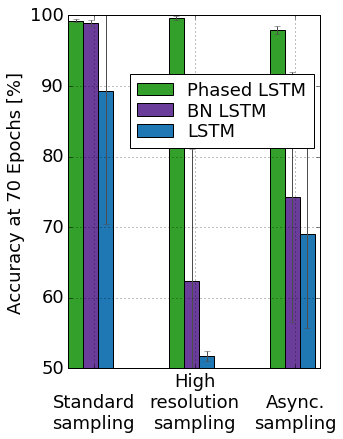

In [4]:
N = 3

ind = np.arange(N)  # the x locations for the groups
width = 0.15        # the width of the bars

# Generate the figure and color the error bars
fig, ax = plt.subplots(figsize=(5, 7))
error_config = {'ecolor': '0.3'}

# Draw the bar plots
rects1 = ax.bar(ind + 0*width, means[:,0], width, color=PLSTM_COLOR, yerr=stds[:,0], error_kw=error_config)
rects2 = ax.bar(ind + 1*width, means[:,1], width, color=BN_LSTM_COLOR, yerr=stds[:,1], error_kw=error_config)
rects3 = ax.bar(ind + 2*width, means[:,2], width, color=LSTM_COLOR, yerr=stds[:,2], error_kw=error_config)

# Add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy at 70 Epochs [%]')
ax.set_xticks(ind + 1.7*width)
ax.set_xticklabels(('\nStandard\nsampling', 'High\nresolution\nsampling', '\nAsync.\nsampling'))
axbox = ax.get_position()
ax.legend((rects1[0], rects2[0], rects3[0]), ('Phased LSTM', 'BN LSTM', 'LSTM'), 
          loc=(axbox.x0 + 0.12, axbox.y0 + 0.5), labelspacing=0.15, fontsize=18)
plt.grid(which='both')
plt.ylim([50, 100])

# Adjust the figure for saving
plt.gcf().subplots_adjust(bottom=0.2, left=0.2)
plt.savefig('images/task1_acc_bar.pdf')
plt.savefig('images/task1_acc_bar.png')